# MIMO Drive Prediction with Response Limiting
This notebook demonstrates how ForceFinder can be used for shaker drive prediction in MIMO random vibration testing. It extends the [basic SPR utilization example](basic_spr_utilization) with additional excitation DOFs and a response limiting scheme. This example uses the beam system that was developed [here](sec:example_beam_system) with a random vibration specification that is developed from a single DOF vibration specification in MIL-STD 810H. An image of the beam system is shown below, the blue arrows (the straight arrows above the beam) are the control DOFs for the vibration test, the red arrows (below the beam) are the excitation DOFs, and the yellow arrows (the curved arrows above the beam) are the DOFs with response limits. 

```{note}
The straight arrows indicate a translating DOF and the curved arrows indicate a rotating DOF. The nodes are labeled 101-109 from left to right. The translating direction on the beam (vertical on the page) is Z+ and the rotating direction is RY+.
```

```{figure} images/beam_system_limit_dofs.svg
:alt: Beam System with Limit DOFs
:align: center
```

The example data for this beam system is generated using the following process:

1. The SDynPy `System` object for the beam is imported
2. FRFs are computed for the beam system using the `frequency_response` method for the beams `System` object
3. A CPSD specification is made from a single DOF vibration specification from MIL-STD 810H
4. Response limits will be defined with a `ResponseLimit` object

In [16]:
import sdynpy as sdpy
import forcefinder as ff
import numpy as np
import matplotlib.pyplot as plt

In [2]:
beam_system = sdpy.System.load(r'./example_system/example_system.npz')

## Computing the FRFs
The FRFs are computed using a bandwidth of 5-500 Hz (which matches the specification that is defined below) and a frequency resolution 1 Hz. The displacement derivative is set to two, meaning the the FRFs are in accelerance format. The ordinate of the FRFs is divided by 9.81 to convert the FRFs from SI units to SI-G units (acceleration in Gs).

```{note}
The FRFs are computed in acceleration/force units, based on limitations of the model. This is being used as an analog for the acceleration/voltage units that are common in MIMO vibration testing.
```

In [93]:
frf_frequency = np.arange(496)+5
drive_coordinate = sdpy.coordinate_array(node=[102,104,106,108], direction=3)

frfs = beam_system.frequency_response(frf_frequency,
                                      references=drive_coordinate, 
                                      displacement_derivative=2)
frfs.ordinate /= 9.81

## Specification
The specification for this example is based off the unknonwn orientation "common carrier (US highway truck vibration exposure)" single DOF vibration specification that is defined in method 514.8, annex C of MIL-STD 810H. This example problem is treating the beam as a shaker table, meaning that the goal is to control the beam as a rigid body. This is specified by applying same single axis specification PSD to each control DOF. The cross-terms for the specification CPSD is defined by a coherence 0.9 between each DOF and zero phase between each DOF. 

```{note}
The approach of applying a single axis vibration specification equally to all the control DOFs is for demonstration purposes only and should not be treated as an endorsement of the method. It is up to the practitioner to determine an optimal approach for developing a MIMO vibration specification.
```

The specification from MIL-STD 810H is provided as a set of PSD breakpoints, which must be converted to a narrow band PSD before it can be turned into a MIMO specification. This conversion is done using log-log interpolation.

In [94]:
breakpoint_frequencies = [5,     40,    120,      121,   200,   240,    266,      500]
breakpoint_amplitudes =  [0.015, 0.015, 0.002025, 0.003, 0.003, 0.0015, 0.000475, 0.00015]

narrowband_specification = 10**(np.interp(np.log10(frf_frequency), 
                                          np.log10(breakpoint_frequencies), 
                                          np.log10(breakpoint_amplitudes)))

The coherence and phase for the specification are manually defined. Note that several extra steps are used in this code block to shape the arrays for the necessary operations. 

In [104]:
specification_psd = narrowband_specification[...,np.newaxis]*np.array(([[1,1,1,1]]*frf_frequency.shape[0]))

specification_phase = np.zeros((frf_frequency.shape[0],4,4), dtype=float)

specification_coherence = np.ones((4,4), dtype=float)*0.9
np.fill_diagonal(specification_coherence, 1)
specification_coherence = np.broadcast_to(specification_coherence[np.newaxis,...], 
                                          (frf_frequency.shape[0],4,4))

The PSDs, coherence, and phase are used to generate the full specification CPSD matrix for the simulated MIMO test using the `cpsd_from_coh_phs` function in SDynPy. The specification CPSD is initially generated as an `ndarray` in `specification_cpsd`. This `ndarray` is then populated into a SDynPy `PowerSpectralDensityArray` in `specification`.

In [ ]:
specification_dofs = sdpy.coordinate_array(node=[102,104,106,108], direction=3)

specification_cpsd = sdpy.signal_processing.cpsd.cpsd_from_coh_phs(specification_psd, 
                                                                   specification_coherence, 
                                                                   specification_phase)

specification = sdpy.power_spectral_density_array(frf_frequency, 
                                                  np.moveaxis(specification_cpsd,0,-1),
                    sdpy.coordinate.outer_product(specification_dofs, specification_dofs))

## Defining the Limit
Limits for the different DOFs are defined below in a `ResponseLimit` object, which contains all the limits for the simulated MIMO test. This example shows one way to define the `ResponseLimit` object, refer to the [API documentation](autoapi/forcefinder/core/response_limit/index) for more details.

```{note}
Contrived limits are used here to limit the rotation of the beam. The breakpoints were chosen to demonstrate the flexibility of the `ResponseLimit` object and ensure that the limits would effect the estimated drives.
```

```{tip}
Response limits do not need to be defined for the full test bandwidth and a different number of breakpoints can be used for the different limits in the object. The main requirement for using a ResponseLimit object is that FRF data must exist to predict the response PSDs at the limit DOFs. 
```

In [ ]:
example_limit = ff.ResponseLimit(limit_coordinate=['105RY+', '107RY+'],
                                 breakpoint_frequency=[[200, 400], # 105RY+
                                                       [50, 150, 250, 280, 500]], # 107RY+
                                 breakpoint_level=[[0.03, 0.03], # 105RY+
                                                   [0.1, 0.5, 1, 0.01, 0.01]]) # 107RY+

## Creating the SPR Object without a Response Limit
This section creates the basic SPR object and estimates the drives with the basic pseudo-inverse method without enforcing the response limits. The control accuracy is evaluated using the `error_summary` method, which shows that the PSDs are controlled with line-on-line accuracy. Although it is not shown here, the phase and coherence is controlled with similar accuracy. 

In [107]:
no_limit_spr = ff.PowerSourcePathReceiver(frfs, specification)
no_limit_spr.manual_inverse()

'PowerSourcePathReceiver object with 4 reference coordinates, 4 target response coordinates, and 4 training response coordinates'

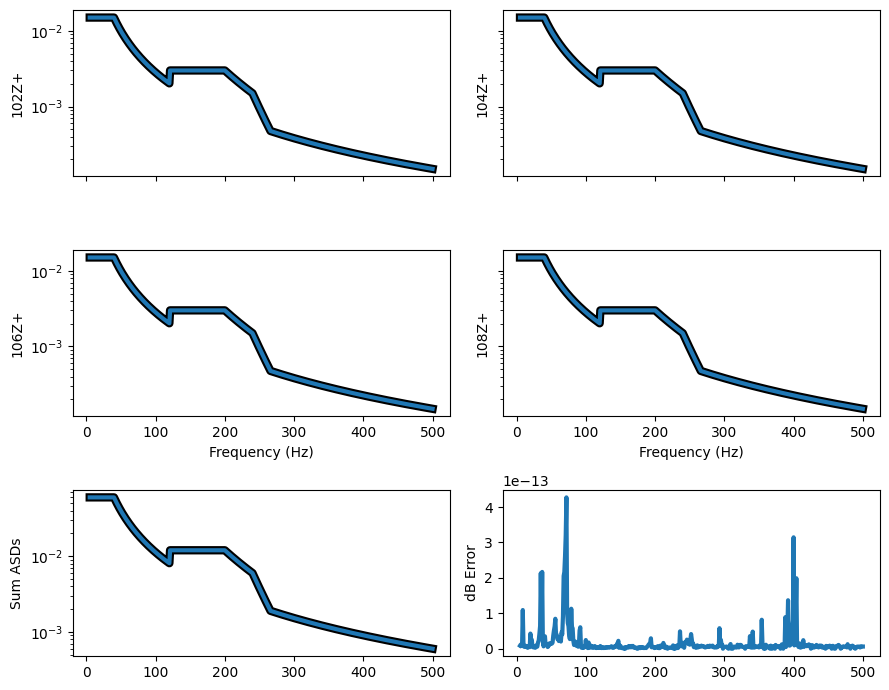

In [ ]:
no_limit_spr.error_summary(figure_kwargs={'figsize':(9,7)}, linewidth=5)

The predicted responses (from the estimated drives) are compared to the response limits, showing that there are several frequencies where the limits are exceeded. 

```{note}
The predicted responses are compared to the limits on log-log plots since that is how limits are commonly specified in vibration testing. 
```

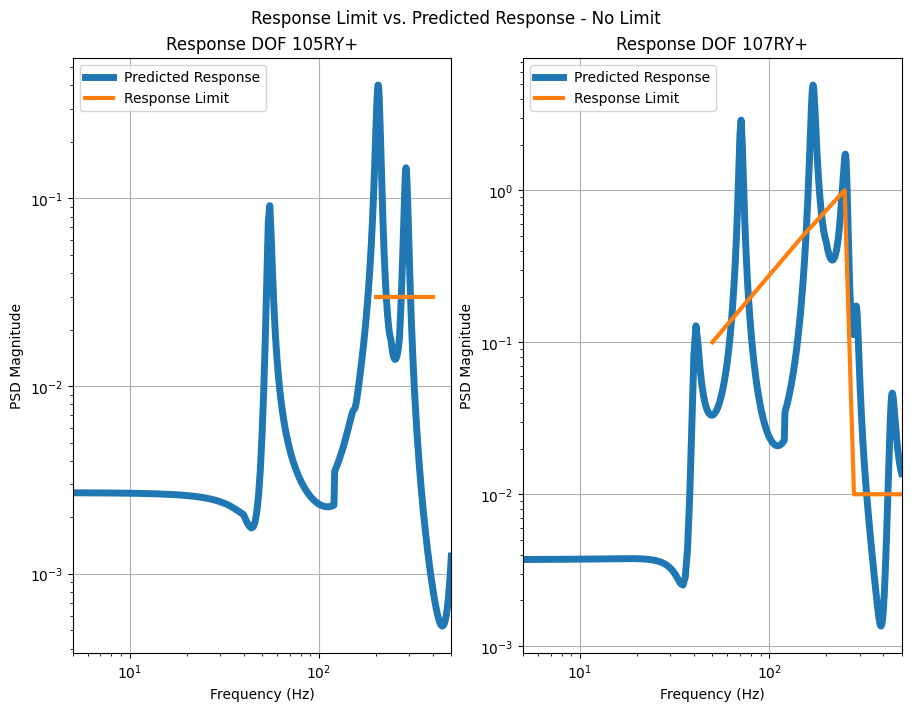

In [109]:
fig, ax = plt.subplots(1,2, layout='constrained', figsize=(9,7))
fig.suptitle('Response Limit vs. Predicted Response - No Limit')

ax[0].loglog(no_limit_spr.abscissa, np.abs(no_limit_spr.predicted_response_specific_dofs(example_limit[0].limit_coordinate).ordinate[0,0,:]),
             label='Predicted Response', linewidth=5)
ax[0].loglog(example_limit[0].breakpoint_frequency, example_limit[0].breakpoint_level, 
             label='Response Limit', linewidth=3)
ax[0].grid()
ax[0].legend()
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('PSD Magnitude')
ax[0].set_xlim(left=5, right=500)
ax[0].set_title('Response DOF '+example_limit[0].limit_coordinate.string_array()[0]);

ax[1].loglog(no_limit_spr.abscissa, np.abs(no_limit_spr.predicted_response_specific_dofs(example_limit[1].limit_coordinate).ordinate[0,0,:]),
             label='Predicted Response', linewidth=5)
ax[1].loglog(example_limit[1].breakpoint_frequency, example_limit[1].breakpoint_level, 
             label='Response Limit', linewidth=3)
ax[1].grid()
ax[1].legend()
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('PSD Magnitude')
ax[1].set_xlim(left=5, right=500)
ax[1].set_title('Response DOF '+example_limit[1].limit_coordinate.string_array()[0]);


## Applying the Limits
The response limits are applied by supplying the `example_limit` object to the `apply_response_limit` method for the `PowerSourcePathReceiver`. There are three important options for the `apply_response_limit` method:

1. `limit_db_level`: This option determines if the limit should be adjusted by the supplied dB level. This is important for cases where the limits were developed for a specific test level that is different from what is being used. For example, the limit may have been developed for a "qualification" level whereas the test is being ran at a "workmanship" (e.g., -6 dB) level. 
2. `interpolation_type`: This option determines how the limit breakpoints will be interpolated to the abscissa for the SPR object. Essentially, this determines if the lines between breakpoints should be straight on a linear-linear or log-log plot.
3. `in_place`: This determines if the `apply_response_limit` method should save the modified drives to the original SPR object or if it should return a new SPR object with the original object unchanged. 

In [110]:
limit_spr = no_limit_spr.apply_response_limit(example_limit, 
                                              limit_db_level=0,
                                              interpolation_type='loglog', 
                                              in_place=False)

It is generally good practice to evaluate how [scaling the drives](sec:response_limiting) to enforce the response limit effects the accuracy of the test. This is done below with the `error_summary` method. These plots show that enforcing the response limits cause significant errors in the frequency bands that exceed the limit.

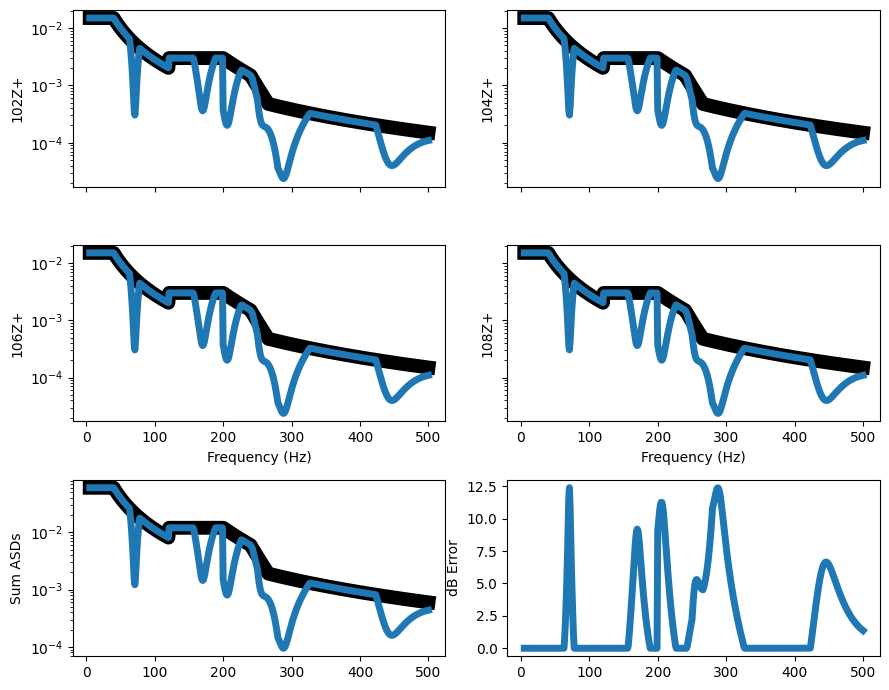

In [115]:
limit_spr.error_summary(figure_kwargs={'figsize':(9,7)}, linewidth=5)

The predicted responses from the drives with the limits enforced show that the updated prediction is compliant with the limits. This plot also shows how a limit on one DOF can supersede the limit on another DOF, since the 300 Hz peak in 105RY+ is dramatically reduced by the limit that is applied to 107RY+.   

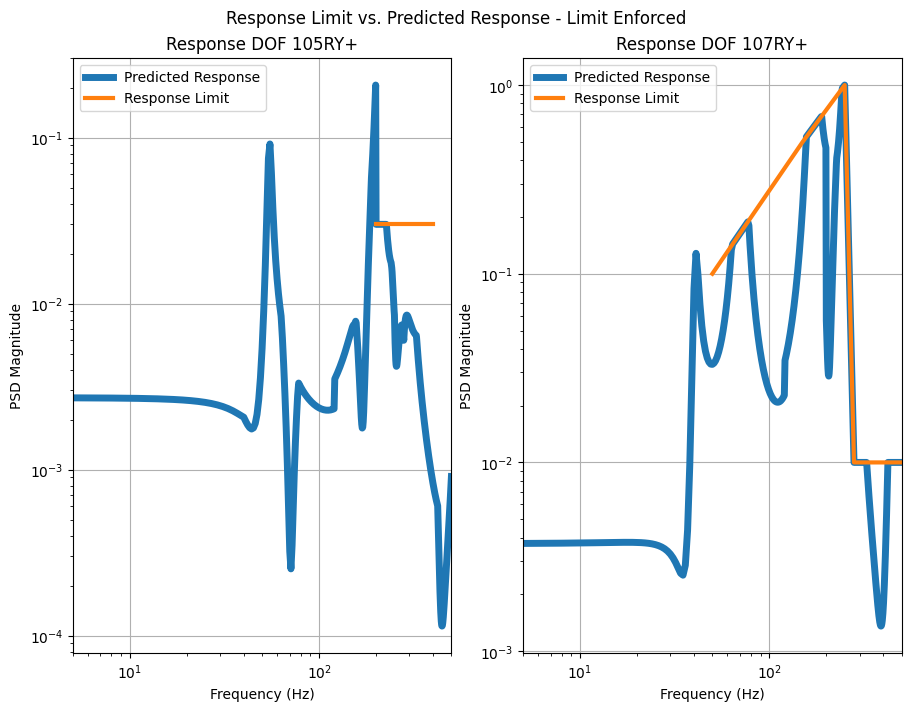

In [112]:
fig, ax = plt.subplots(1,2, layout='constrained', figsize=(9,7))
fig.suptitle('Response Limit vs. Predicted Response - Limit Enforced')

ax[0].loglog(limit_spr.abscissa, np.abs(limit_spr.predicted_response_specific_dofs(example_limit[0].limit_coordinate).ordinate[0,0,:]),
             label='Predicted Response', linewidth=5)
ax[0].loglog(example_limit[0].breakpoint_frequency, example_limit[0].breakpoint_level, 
             label='Response Limit', linewidth=3)
ax[0].grid()
ax[0].legend()
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('PSD Magnitude')
ax[0].set_xlim(left=5, right=500)
ax[0].set_title('Response DOF '+example_limit[0].limit_coordinate.string_array()[0]);

ax[1].loglog(limit_spr.abscissa, np.abs(limit_spr.predicted_response_specific_dofs(example_limit[1].limit_coordinate).ordinate[0,0,:]),
             label='Predicted Response', linewidth=5)
ax[1].loglog(example_limit[1].breakpoint_frequency, example_limit[1].breakpoint_level, 
             label='Response Limit', linewidth=3)
ax[1].grid()
ax[1].legend()
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('PSD Magnitude')
ax[1].set_xlim(left=5, right=500)
ax[1].set_title('Response DOF '+example_limit[1].limit_coordinate.string_array()[0]);